In [87]:
from google.colab import drive
drive.mount('/content/drive')

!pwd
%cd /content/drive/MyDrive/ML2023/data-analysis
# !ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/ML2023/data-analysis
/content/drive/MyDrive/ML2023/data-analysis


# **CLASSIFIER**

*This algorithm will identify the optimal classification machine learning model for a given dataset.*

# Import the helper classes

In [88]:
!pip install AutoLogging-ML
!pip install xgboost
!pip install catboost

In [89]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import math
from plotly.subplots import make_subplots
from AutoLogging_ML import AutoLogger
import seaborn as sns

from aka_data_analysis.aka_plot import aka_plot, aka_correlation_analysis
from aka_data_analysis.aka_learning import aka_learn,aka_clean,aka_filter

aka_plot = aka_plot()
aka_corr_an = aka_correlation_analysis()
aka_clean = aka_clean()
aka_learn = aka_learn()
aka_filter = aka_filter()
aka_corr_an = aka_correlation_analysis()

In [90]:
import warnings
from sklearn.exceptions import FitFailedWarning
# Filter out the FitFailedWarning
warnings.filterwarnings("ignore", category=FitFailedWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [91]:
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import plotly.figure_factory as ff
import plotly.express as px
import numpy as np
import pandas as pd


# Dataset Information




The data is provided by: https://www.kaggle.com/datasets/prathamtripathi/drug-classification

# Import Dataset

In [92]:
df = aka_clean.df_get('Drug_Classification/drug200.csv')

In [93]:
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [95]:
df.describe()

,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


# Clean Data

## Drop Duplicate data

In [96]:
df.drop_duplicates()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY
...,...,...,...,...,...,...
195,56,F,LOW,HIGH,11.567,drugC
196,16,M,LOW,HIGH,12.006,drugC
197,52,M,NORMAL,HIGH,9.894,drugX
198,23,M,NORMAL,NORMAL,14.020,drugX


## Swap the target and the last feature

In [97]:
df = aka_clean.swap_features(df,-1)
df.head()

Invalid feature indices or feat_a is equal to feat_b.


,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


## Drop feature(s)


In [98]:
feat = []
df = aka_clean.drop_feature(df,feat)
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


##  Convert categorical variables into numerical representations

In [99]:
mapping,swapMapping = aka_clean.CleaningVar(df)
df = aka_clean.CleaningDF(df,mapping)
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,0,0,0,25.355,0
1,47,1,1,0,13.093,1
2,47,1,1,0,10.114,1
3,28,0,2,0,7.798,2
4,61,0,1,0,18.043,0


## Balance Dataset

In [100]:
aka_plot.plot_pie(df,-1)

In [101]:
# df = aka_clean.balance_df(df,'j')
# aka_plot.plot_pie(df, -1)

## Clean Dataset

## Correlation Matrix

In [102]:
aka_corr_an.Plot_Correlation_Matrix(df)

In [103]:

confidence_interval_limit =   [-10,10]             # Define the limits m of the confidence interval [-m, m] and eliminate the outliers'''

correlation_percentage_threshold = .7      # Set the limit of the correlation between the feature to be removed

df_filtered,corr_tmp = aka_learn.filter_drop_corr_df(df,confidence_interval_limit,correlation_percentage_threshold)

diff_shape = (df.shape[0]-df_filtered.shape[0],df.shape[1]-df_filtered.shape[1])
diff_shape,df_filtered.shape

((0, 0), (200, 6))

## Graph the features that are highly correlated


In [104]:
fig = aka_corr_an.Plot_Correlate_Features(df,list(corr_tmp),400,500,3)
if fig is not None:
    fig.show()

Empty list is provided.


## Visualize the distribution of the filtered dataset

In [105]:
aka_plot.Plot_box_Features(df,df_filtered,400,500,3,range(df_filtered.shape[1]))

# Search for the most effective ML algorithm to learn the dataset

In [106]:
pre_proc = 'X'                             # Choose between 'XY' to standardize both 'X' and 'Y',
                                              #                'X' to standardize only 'X',
                                              #                'Y' to standardize only 'Y',

X_train, X_test, y_train, y_test = aka_learn.Learning_data(df_filtered,pre_proc)

In [107]:

r,model =AutoLogger.train_and_log_classification(X_train,y_train,X_test,y_test,size='large')
y_pred = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:951: RuntimeWarning:

divide by zero encountered in power

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:951: RuntimeWarning:

invalid value encountered in multiply

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:954: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:951: RuntimeWarning:

divide by zero encountered in power

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:951: RuntimeWarning:

invalid value encountered in multiply

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:954: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:951: RuntimeWarning:

divide by zero encountered in power

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:951

In [108]:
model

DecisionTreeClassifier()

<Axes: xlabel='validation-accuracy', ylabel='model'>

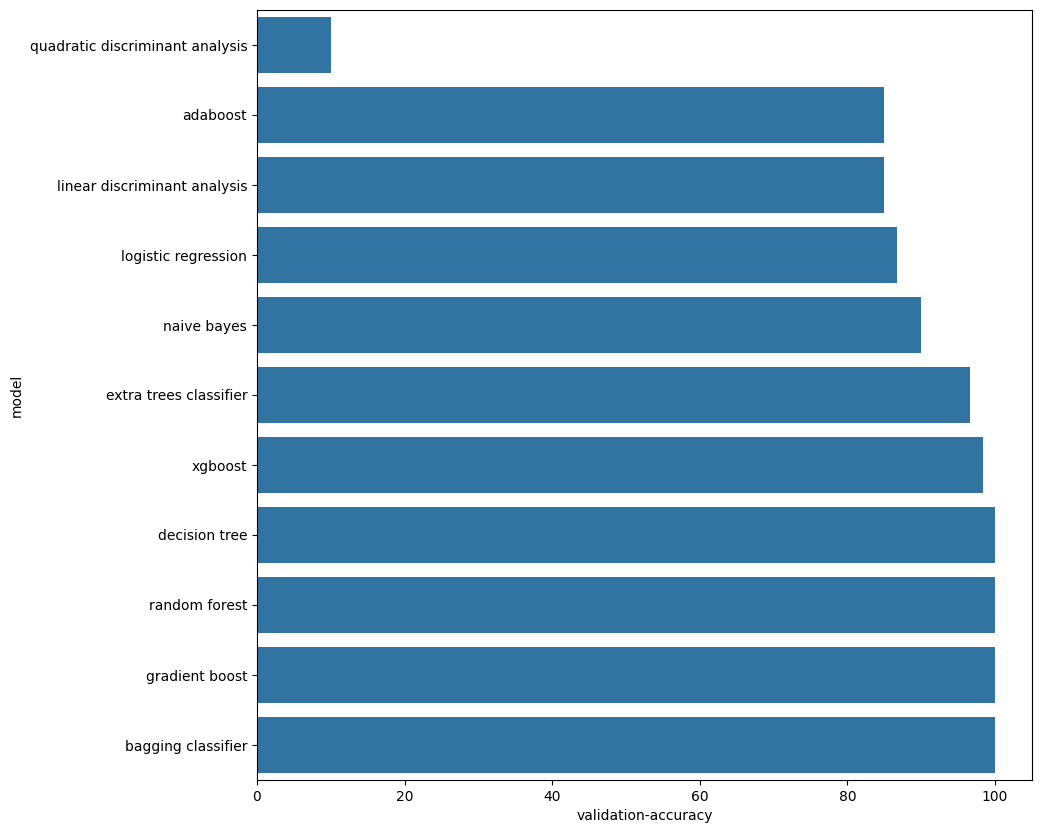

In [109]:
AutoLogger.get_metric_plot_classification(r,'validation','accuracy')

## Confusion Matrix

In [110]:
y_pred_ = aka_clean.swap_map(y_pred,swapMapping)
y_test_ = aka_clean.swap_map(y_test,swapMapping)
Label = [ str(un) for un in np.unique(pd.concat([y_pred_, y_test_]))]

In [111]:
shw = 1
fig2 =  aka_plot.plot_confusion_matrix(y_test_,y_pred_,Label,shw)
fig2.show()

## Classification Report

In [112]:
shw = 1
fig3 =  aka_plot.plot_classification_report(y_test_,y_pred_,Label,shw)
fig3.show()